In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
transform = transforms.Compose([
    transforms.ToTensor()   # converts 0–255 → 0–1
])

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.4MB/s]


In [3]:
batch_size = 128

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False)


In [4]:
images, labels = next(iter(train_loader))
print(images.shape)
# train_loader provieds data batch by batch
# iter creates an iterator

torch.Size([128, 1, 28, 28])


In [5]:
latent_dim = 20
# 784 → Encoder → 20 numbers → Decoder → 784
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

def reparameterize(mu, logvar): #helps with backpropagation
      std = torch.exp(0.5 * logvar)
      eps = torch.randn_like(std)
      z = mu + std * eps
      return z

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim, 400)
        self.fc2 = nn.Linear(400, 784)

    def forward(self, z):
        z = torch.relu(self.fc1(z))
        x_hat = torch.sigmoid(self.fc2(z))
        return x_hat

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

model = VAE()
print(model)


VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=400, bias=True)
    (fc_mu): Linear(in_features=400, out_features=20, bias=True)
    (fc_logvar): Linear(in_features=400, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=20, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=784, bias=True)
  )
)


In [6]:
reconstruction_loss_fn = nn.BCELoss(reduction="sum")
def kl_divergence(mu, logvar):
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return kl
def vae_loss(x_hat, x, mu, logvar):
    recon_loss = reconstruction_loss_fn(x_hat, x)
    kl_loss = kl_divergence(mu, logvar)
    return recon_loss + kl_loss

optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
train_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, _ in train_loader:

        images = images.view(-1, 784)
        images = images.to(device)

        optimizer.zero_grad()

        x_hat, mu, logvar = model(images)

        loss = vae_loss(x_hat, images, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/20], Loss: 162.6880
Epoch [2/20], Loss: 121.3395
Epoch [3/20], Loss: 114.4287
Epoch [4/20], Loss: 111.5282
Epoch [5/20], Loss: 109.7915
Epoch [6/20], Loss: 108.6432
Epoch [7/20], Loss: 107.7944
Epoch [8/20], Loss: 107.1323
Epoch [9/20], Loss: 106.6336
Epoch [10/20], Loss: 106.1994
Epoch [11/20], Loss: 105.8386
Epoch [12/20], Loss: 105.5612
Epoch [13/20], Loss: 105.2754
Epoch [14/20], Loss: 105.0348
Epoch [15/20], Loss: 104.8291
Epoch [16/20], Loss: 104.5892
Epoch [17/20], Loss: 104.4415
Epoch [18/20], Loss: 104.2708
Epoch [19/20], Loss: 104.0996
Epoch [20/20], Loss: 103.9555


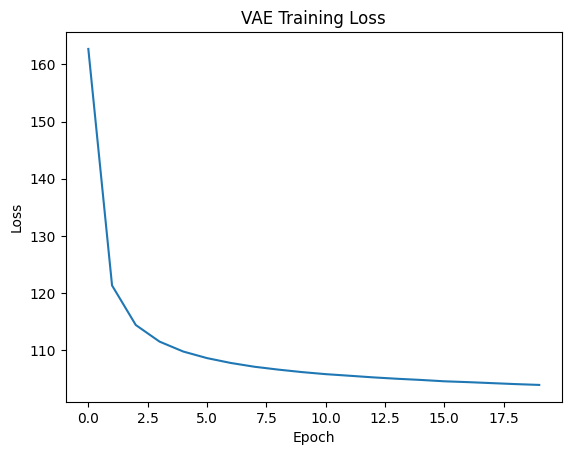

In [7]:
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.show()


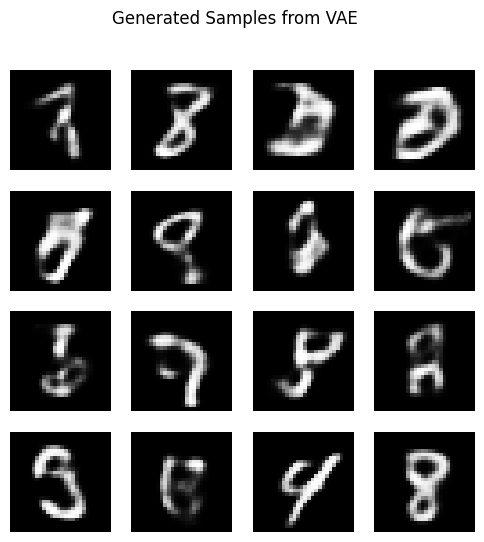

In [9]:
model.eval()
num_samples = 16
z = torch.randn(num_samples, latent_dim).to(device)

with torch.no_grad():
    generated = model.decoder(z)
generated = generated.view(-1, 1, 28, 28)
plt.figure(figsize=(6,6))

for i in range(num_samples):
    plt.subplot(4,4,i+1)
    plt.imshow(generated[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

plt.suptitle("Generated Samples from VAE")
plt.show()


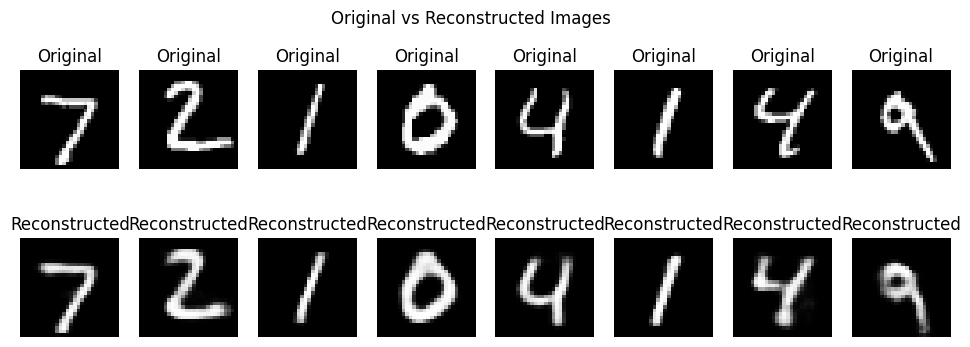

In [10]:
model.eval()
images, _ = next(iter(test_loader))
images = images.view(-1, 784).to(device)
with torch.no_grad():
    recon_images, _, _ = model(images)
images = images.view(-1, 1, 28, 28)
recon_images = recon_images.view(-1, 1, 28, 28)
n = 8

plt.figure(figsize=(12,4))

for i in range(n):

    plt.subplot(2, n, i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, n, i+1+n)
    plt.imshow(recon_images[i].cpu().squeeze(), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.suptitle("Original vs Reconstructed Images")
plt.show()


In [11]:
def ae_loss(x_hat, x):
    return reconstruction_loss_fn(x_hat, x)
model_no_kl = VAE().to(device)
optimizer_no_kl = optim.Adam(model_no_kl.parameters(), lr=1e-3)
epochs = 20
train_losses_no_kl = []

for epoch in range(epochs):
    model_no_kl.train()
    total_loss = 0

    for images, _ in train_loader:

        images = images.view(-1, 784).to(device)

        optimizer_no_kl.zero_grad()

        x_hat, mu, logvar = model_no_kl(images)

        loss = ae_loss(x_hat, images)

        loss.backward()
        optimizer_no_kl.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses_no_kl.append(avg_loss)

    print(f"[NO KL] Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


[NO KL] Epoch [1/20], Loss: 133.8246
[NO KL] Epoch [2/20], Loss: 82.3275
[NO KL] Epoch [3/20], Loss: 76.0732
[NO KL] Epoch [4/20], Loss: 73.3062
[NO KL] Epoch [5/20], Loss: 71.5966
[NO KL] Epoch [6/20], Loss: 70.3863
[NO KL] Epoch [7/20], Loss: 69.4872
[NO KL] Epoch [8/20], Loss: 68.7945
[NO KL] Epoch [9/20], Loss: 68.2235
[NO KL] Epoch [10/20], Loss: 67.7274
[NO KL] Epoch [11/20], Loss: 67.3232
[NO KL] Epoch [12/20], Loss: 66.9686
[NO KL] Epoch [13/20], Loss: 66.6638
[NO KL] Epoch [14/20], Loss: 66.3913
[NO KL] Epoch [15/20], Loss: 66.1504
[NO KL] Epoch [16/20], Loss: 65.9125
[NO KL] Epoch [17/20], Loss: 65.7125
[NO KL] Epoch [18/20], Loss: 65.5330
[NO KL] Epoch [19/20], Loss: 65.3704
[NO KL] Epoch [20/20], Loss: 65.2038


In [12]:
model_no_kl.eval()

images, _ = next(iter(test_loader))
images = images.view(-1, 784).to(device)

with torch.no_grad():
    recon_no_kl, _, _ = model_no_kl(images)

images = images.view(-1,1,28,28)
recon_no_kl = recon_no_kl.view(-1,1,28,28)


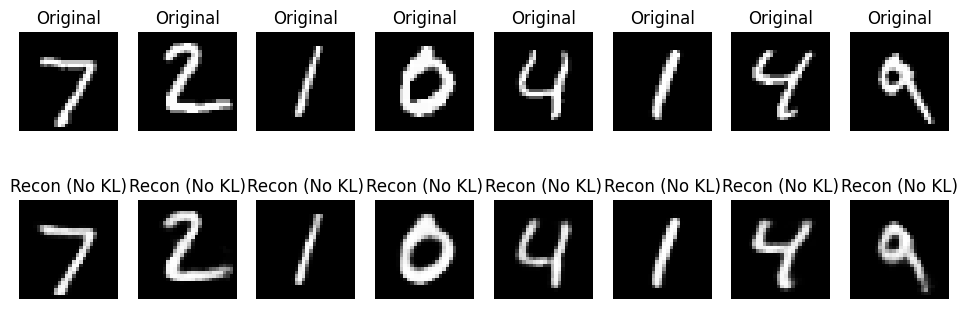

In [13]:
n = 8
plt.figure(figsize=(12,4))

for i in range(n):

    plt.subplot(2,n,i+1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2,n,i+1+n)
    plt.imshow(recon_no_kl[i].cpu().squeeze(), cmap="gray")
    plt.title("Recon (No KL)")
    plt.axis("off")

plt.show()


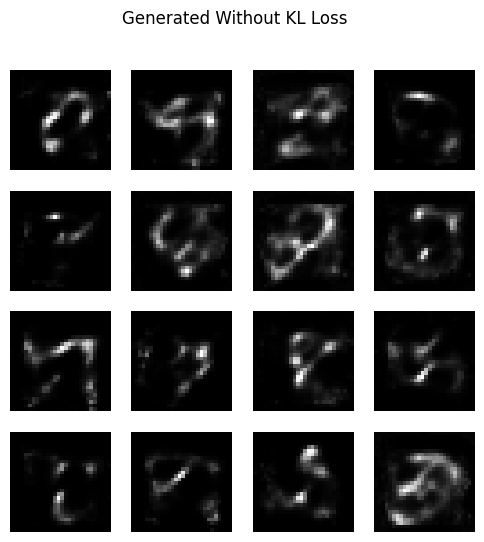

In [15]:
z = torch.randn(16, latent_dim).to(device)

with torch.no_grad():
    gen_no_kl = model_no_kl.decoder(z)

gen_no_kl = gen_no_kl.view(-1,1,28,28)
plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(gen_no_kl[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")
plt.suptitle("Generated Without KL Loss")
plt.show()
